**In this Notebook, we present an approach without using pretrained embeddings with Machine Learning approaches to predict the funniness score of a news headline from the humicroedit dataset**

**1. Introduction**

In Natural language Processing, humour detection is a challenging task. The [SemEval-2020 Task 7](https://arxiv.org/pdf/2008.00304.pdf)  aims to detect humour in English news headlines from micro-edits. The humicroedit dataset (Hossain et al., 2020) contains 9653 training, 2420 development and 3025 testing examples. In task 1 the goal is to predict the the funniness score of an edited headline in the ranges of 0 to 3, where 0 means not funny and 3 means very funny. 

**2. Import and Downloads**

In [30]:
#@title Imports
# Library imports
import pandas as pd
import numpy as np
import seaborn as sns
import torch
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import (
    RandomForestRegressor,
    GradientBoostingRegressor,
    AdaBoostRegressor,
)
from sklearn.svm import SVR
import xgboost as xgb
from preprocessing.preprocessor import (create_edited_sentences, dataset_question_full_processing,
                                        create_custom_vocab, get_stop_words)
from utils.metrics import model_performance

**3. Data Loading**

In [11]:
# Load data
train_df = pd.read_csv('data/task-1/train.csv')
dev_df = pd.read_csv('data/task-1/dev.csv')
test_df = pd.read_csv('data/task-1/test.csv')

# Convert them to full edited sentences
modified_train_df = create_edited_sentences(train_df)
modified_valid_df = create_edited_sentences(dev_df)
modified_test_df = create_edited_sentences(test_df)

**4. Preprocessing**

***Stop Words***

In [12]:
# nltk stopwords english list
nltk.download('stopwords')
nltk_stopwords = list(stopwords.words('english'))

# import custom stopword list
simple_stopwords, custom_stopwords = get_stop_words()

all_stopwords = list(set(custom_stopwords + nltk_stopwords))

stopwords_lists = [[],simple_stopwords, custom_stopwords,nltk_stopwords,\
                   all_stopwords]
edited_modes = ['question_edited','full_edited']

# OK Applying both question and full version to any dataframe and dropping useless values
modified_train_df = dataset_question_full_processing(modified_train_df)
modified_valid_df = dataset_question_full_processing(modified_valid_df)
modified_test_df = dataset_question_full_processing(modified_test_df)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nasmadasser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


***Train-Test-Dev split***

In [15]:
train_proportion =0.8
train_and_dev = train_df['edit']
training_data, dev_data, training_y, dev_y = train_test_split(train_df['edit'], train_df['meanGrade'],
                                                                        test_size=(1-train_proportion),
                                                                        random_state=42)

**5. Baseline Approach: TF-IDF + Linear Regression**

In [16]:
# We train a Tf-idf model
count_vect = CountVectorizer(stop_words='english')
train_counts = count_vect.fit_transform(training_data)
transformer = TfidfTransformer().fit(train_counts)
train_counts = transformer.transform(train_counts)
regression_model = LinearRegression().fit(train_counts, training_y)

In [17]:
# Train predictions
predicted_train = regression_model.predict(train_counts)

# Calculate Tf-idf using train and dev, and validate model on dev:
test_and_test_counts = count_vect.transform(train_and_dev)
transformer = TfidfTransformer().fit(test_and_test_counts)

test_counts = count_vect.transform(dev_data)

test_counts = transformer.transform(test_counts)

# Dev predictions
predicted = regression_model.predict(test_counts)

***Evaluate the model***

In [20]:
# We run the evaluation:
print("\nTrain performance:")
sse, mse = model_performance(predicted_train, training_y, True)

print("\nDev performance:")
sse, mse = model_performance(predicted, dev_y, True)


Train performance:
| MSE: 0.13 | RMSE: 0.37 |

Dev performance:
| MSE: 0.36 | RMSE: 0.60 |


***Baseline Mean***

In [22]:
# Baseline for the task
pred_baseline = torch.zeros(len(dev_y)) + np.mean(training_y)
print("\nBaseline performance:")
sse, mse = model_performance(pred_baseline, dev_y, True)


Baseline performance:
| MSE: 0.34 | RMSE: 0.58 |


***6. Machine Learning Models***

***Preprocessing***

In [24]:
 # TFIDF Vectorizer of the sentences, four models with different stop words
tfidfconverter_nostopword = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7)
tfidfconverter_simple = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7, stop_words=simple_stopwords)
tfidfconverter_custom = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7, stop_words=custom_stopwords)
tfidfconverter_nltk = TfidfVectorizer(max_features=2000, min_df=5, max_df=0.7, stop_words=nltk_stopwords)
tfidfconverters = [tfidfconverter_nostopword, tfidfconverter_simple, tfidfconverter_custom, tfidfconverter_nltk]

x_tfs = []
# create a list of the edited datasets
for tfidfconverter in tfidfconverters:
  x_tfs.append((tfidfconverter.fit_transform(modified_train_df['full_edited']).toarray(),\
                     tfidfconverter.transform(modified_valid_df['full_edited']).toarray()))

ytrain = list(modified_train_df['meanGrade'])
yvalid = list(modified_valid_df['meanGrade'])

/Users/nasmadasser/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['aren', 'can', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [25]:
model_results = {}

# function to dispaly results after running the models
def display_with_panda(data):
  internal_data = [["no stopword",data[0]],["simple stopwords",data[1]],["custom stopwords",data[2]],["nltk stopwords",data[3]]]
  return pd.DataFrame(internal_data, columns=["Stopword list","Full edited"])

***Model 1: XGBoost***

In [26]:
# first XGBoost model
xgboost_data = []
for xtrain_tf, xvalid_tf in x_tfs:
  model = xgb.XGBRegressor()
  xgb_model = model.fit(xtrain_tf, ytrain)
  prediction = xgb_model.predict(xvalid_tf)
  sse, mse = model_performance(prediction, yvalid, print_output=True)
  xgboost_data.append(f'| MSE: {mse:.4f} | RMSE: {np.sqrt(mse):.4f} |')
# store the results
model_results["XGBoost"] = xgboost_data
# display the results
display_with_panda(xgboost_data)

| MSE: 0.34 | RMSE: 0.59 |
| MSE: 0.34 | RMSE: 0.58 |
| MSE: 0.34 | RMSE: 0.59 |
| MSE: 0.34 | RMSE: 0.58 |


,Stopword list,Full edited
0,no stopword,| MSE: 0.3430 | RMSE: 0.5857 |
1,simple stopwords,| MSE: 0.3392 | RMSE: 0.5824 |
2,custom stopwords,| MSE: 0.3422 | RMSE: 0.5850 |
3,nltk stopwords,| MSE: 0.3413 | RMSE: 0.5842 |


***Model 2: Random Forest***

In [27]:
# Random Forest with estimator number = 50
randomforest_data = []
for xtrain_tf, xvalid_tf in x_tfs:
  rf_reg = RandomForestRegressor(n_estimators=50, n_jobs=-1, verbose=1, random_state=42)
  rf_reg.fit(xtrain_tf, ytrain)
  prediction = rf_reg.predict(xvalid_tf)
  sse, mse = model_performance(prediction, yvalid, print_output=True)
  randomforest_data.append(f'| MSE: {mse:.4f} | RMSE: {np.sqrt(mse):.4f} |')
# store the results
model_results["Random Forest"] = randomforest_data
# print out results
display_with_panda(randomforest_data)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  5.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished


| MSE: 0.36 | RMSE: 0.60 |


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  5.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  7.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished


| MSE: 0.37 | RMSE: 0.60 |


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  9.7min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.1s finished


| MSE: 0.38 | RMSE: 0.61 |


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  9.3min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  50 out of  50 | elapsed:    0.0s finished


| MSE: 0.37 | RMSE: 0.61 |


,Stopword list,Full edited
0,no stopword,| MSE: 0.3552 | RMSE: 0.5960 |
1,simple stopwords,| MSE: 0.3650 | RMSE: 0.6042 |
2,custom stopwords,| MSE: 0.3752 | RMSE: 0.6125 |
3,nltk stopwords,| MSE: 0.3716 | RMSE: 0.6096 |


*With varying n-estimators*

In [28]:
# fine tune Random forest by varying the number of estimators
results_rf_optimize = {}
xtrain_tf, xvalid_tf=x_tfs[0]
for n in range(40, 101, 20):
    rf_reg = RandomForestRegressor(n_estimators=n, random_state=56, n_jobs=-1)
    rf_reg.fit(xtrain_tf, ytrain)
    predictions = rf_reg.predict(xvalid_tf)
    _, rf_mse = model_performance(predictions, yvalid, print_output=True)
    results_rf_optimize[n] = np.sqrt(rf_mse)
    print(f"N: {n} --> RMSE: {np.sqrt(rf_mse):.4f}")

| MSE: 0.36 | RMSE: 0.60 |
N: 40 --> RMSE: 0.5969
| MSE: 0.35 | RMSE: 0.59 |
N: 60 --> RMSE: 0.5945
| MSE: 0.35 | RMSE: 0.59 |
N: 80 --> RMSE: 0.5936
| MSE: 0.35 | RMSE: 0.59 |
N: 100 --> RMSE: 0.5936


Plot the results

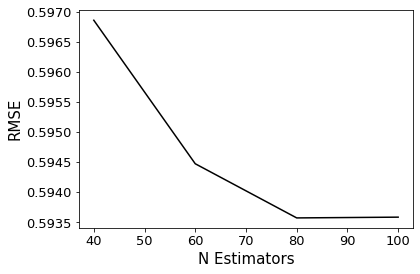

In [31]:
# plot the results depending on the number of estimators
results_df = (
    pd.DataFrame(results_rf_optimize.items(), columns=["n_estimators", "RMSE"])
    .sort_values("n_estimators")
    .reset_index(drop=True))
ax = sns.lineplot(x="n_estimators", y="RMSE", data=results_df, color="k")
#plt.suptitle("Random Forest regressor\nRMSE per # of estimators", fontsize=16)
ax.set_xlabel("N Estimators", fontsize=15)
ax.set_ylabel("RMSE", fontsize=15)
ax.xaxis.set_tick_params(labelsize=13)
ax.yaxis.set_tick_params(labelsize=13)

***Model 3: SVR***

In [32]:
#First identify best kernel
svr_kernel = {}
xtrain_tf, xvalid_tf=x_tfs[2]
for kernel in ["linear", "poly", "rbf", "sigmoid"]:
    svr = SVR(kernel=kernel)
    svr.fit(xtrain_tf, ytrain)
    predictions = svr.predict(xvalid_tf)
    _, rf_mse = model_performance(predictions, yvalid, print_output=True)
    #RMSE =np.sqrt(rf_mse)
    randomforest_data.append(f'| MSE: {mse:.4f} | RMSE: {np.sqrt(mse):.4f} |')
    print(f"{kernel}: {RMSE:.5f}")

| MSE: 0.40 | RMSE: 0.63 |


NameError: name 'RMSE' is not defined

Plot the results

In [ ]:
# plot kernel vs RMSE
ax = sns.barplot(x=list(svr_kernel.keys()), y=list(svr_kernel.values()), color='grey')
# plt.setp(ax.get_xticklabels(), rotation=90);
plt.ylim(.5,.7);
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.set_xlabel('Kernel', fontsize=14);
ax.set_ylabel('RMSE', fontsize=14);
#ax.set_title("RMSE for Different SVR Kernels", fontsize=16);

Choose an RBF Kernel

In [ ]:
#Get results by dataset for poly kernel
svr_results = []
for xtrain_tf, xvalid_tf in x_tfs:
    svr = SVR(kernel='poly')
    svr.fit(xtrain_tf, ytrain)
    predictions = svr.predict(xvalid_tf)
    _, mse = model_performance(predictions, yvalid, print_output=True)
    svr_results.append(f'| MSE: {mse:.4f} | RMSE: {np.sqrt(mse):.4f} |')

model_results["SVR"] = svr_results

# print out results
display_with_panda(svr_results)

**7. Testing with the Best Model**

In [ ]:
# train on the no stop word preprocessing with SVR poly kernel
xtrain_tf, _ =x_tfs[0]

svr = SVR(kernel='poly')
svr.fit(xtrain_tf, ytrain)

In [ ]:
# predict on the test set for best performing model.
test_tf = tfidfconverter_nostopword.transform(modified_test_df['full_edited']).toarray()
predictions = svr.predict(test_tf)
_, mse = model_performance(predictions, task1_truth.meanGrade, print_output=True)
print((f'| MSE: {mse:.4f} | RMSE: {np.sqrt(mse):.4f} |'))